### Import packages and define the namespace for the GPX schema

If you get an error here, you will have to add packages to your Python distribution

In [1]:
import os, string, copy, sys, subprocess
import datetime as datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lxml import etree
from scipy.interpolate import interp1d
from PIL import Image, ExifTags

%matplotlib inline

## Input Variables 

In [2]:
#from EmilyS, modified by Seth to prompt user for home dir, flight #, FA and sensor

# unique to local files:
## use first line to hardcode the working dir, use next 2 lines to prompt for dir
homedir = r'/Data/2018_PlumIsland/2018_015_FA_PlumIs_Feb/test_script/ricoh'
#exampdir = '/Data/2018_PlumIsland/2018_015_FA_PlumIs_Feb/test_script/ricoh'
#homedir = input("What directory contains your raw images and telemtry data in (e.g. "+exampdir+")? ")

flight = input("What flight number do you want to work on (e.g. f6)? ")
#logfile = os.path.join(homedir,'tlogs/', 'f6.gpx')
logfile = os.path.join(homedir,'tlogs/', flight+'.gpx')
#imagefolder = os.path.join(homedir,'images/', 'f6')
imagefolder = os.path.join(homedir,'images/', flight)
imgdir = imagefolder
navcsvoutfile = os.path.splitext(logfile)[0]+'_gpx.csv'
imgoutdir = imagefolder+'_new/'
print ("input nav file is:", logfile,"\noutput nav file is:", navcsvoutfile,"\nworking JPEG dir is:", \
       imagefolder,"\nprocessed JPEG dir is:", imgoutdir)

# Standard:
namespace = {'def': 'http://www.topografix.com/GPX/1/1'}
tfmt_exif = '%Y:%m:%d %H:%M:%S' #2017-05-04 14:14:12
tfmt_gpx = '%Y-%m-%dT%H:%M:%S-00:00' #2017-05-04T14:14:12-04:00
iso_fmt="%Y%m%dT%H%M%SZ"

# Mission info - would be nice for logfile and image folder names to correspond to naming convention, as below

## use first line to hardcode the FA #, use next line to prompt for it
fan = '2018-015-FA' # raw_input('Field activity number (e.g. "2017-010-FA"): ')
surveyid = fan
#fan = input("What is the field activity identifier (e.g. 2018-015-FA)? ")
#uas_id = 'u045' # raw_input('U-number of mission (e.g. "u031"): ')
#fc_id = 'f06r01' # raw_input('Flight number (e.g. "04"): ') raw_input('Camera code (e.g. "r01"): ')
fc_id = 'r01f06' # raw_input('Flight number (e.g. "04"): ') raw_input('Camera code (e.g. "r01"): ')
#fc_id = input("What is the sensor identifier (e.g. r01)? ") 
#senflt = fc_id + flight
    
# WHSC EXIF population
credit = "U.S. Geological Survey"
comment = "Low-altitude aerial photograph of Plum Island, MA from survey {} flight {} (https://cmgds.marine.usgs.gov/fan_info.php?fa={}).".format(fan, flight, fan)
keywords = "Plum Island, Massachusetts, {}, UAS, nadir, USGS".format(fan)

What flight number do you want to work on (e.g. f6)? f6
input nav file is: /Data/2018_PlumIsland/2018_015_FA_PlumIs_Feb/test_script/ricoh/tlogs/f6.gpx 
output nav file is: /Data/2018_PlumIsland/2018_015_FA_PlumIs_Feb/test_script/ricoh/tlogs/f6_gpx.csv 
working JPEG dir is: /Data/2018_PlumIsland/2018_015_FA_PlumIs_Feb/test_script/ricoh/images/f6 
processed JPEG dir is: /Data/2018_PlumIsland/2018_015_FA_PlumIs_Feb/test_script/ricoh/images/f6_new/


In [3]:
# verify the user input data looks right before continuing

input_check = "FA = " + fan + "    flight = "+ flight + "    sensor = " + fc_id #+ "    senflt = " + senflt
print ("input data summary: "+ input_check)

while True:
   answer = input('Does the input data above look right?:')
   if answer.lower().startswith("y"):
        break
   elif answer.lower().startswith("n"):
      print("ok, try to re-run the script and enter the correct FA, flight and sensor")
      sys.exit()

print("Great!! Carry on")

input data summary: FA = 2018-015-FA    flight = f6    sensor = r01f06
Does the input data above look right?:yes
Great!! Carry on



## Functions

In [4]:
#from EmilyS

def gpx_tag_to_pdseries(tree, namespace, tag):
    elist = tree.xpath('./def:trk//def:trkpt//def:'+tag, namespaces=namespace)
    ser = pd.Series([e.text for e in elist], name=tag)
    return(ser)

def write_WHSC_exiftags(imgdir, credit, comment, keywords):
    # Tags that will be identical for all images in the folder
    tagvalues = {}
    tagvalues['imgdir'] = imagefolder
    tagvalues['credit'] = credit
    tagvalues['artist'] = "AIM Group"
    tagvalues['contact'] = "WHSC_data_contact@usgs.gov"
    tagvalues['comment'] = comment
    tagvalues['keywords'] = keywords
    tagvalues['copyright'] = "Public Domain. Please credit {credit}".format(**tagvalues)
    # Write to EXIF
    cmd = """exiftool -Artist="{artist} " -Credit="{credit} " -Contact="{contact} " -comment="{comment} " -sep ", " -keywords="{keywords} " -Caption="{comment} " -Copyright="{copyright} " -CopyrightNotice="{copyright} " -Caption-Abstract="{comment} " -ImageDescription="{comment} " {imgdir}""".format(**tagvalues)
    subprocess.check_call(cmd, shell=True)
    return(True)

## Testing read GPX and make epoch time

In [6]:
#from Chris, modified by EmilyS then modified by Seth
# Parse GPX and extract components into dataframe
tree = etree.parse(logfile)

# latitude and longitude
elist = tree.xpath('./def:trk//def:trkpt',namespaces=namespace)
gpxdf = pd.DataFrame([e.values() for e in elist], columns=['lat', 'lon'])

# all tags (inc time)
taglist = ['time', 'ele', 'ele2', 'course', 'roll', 'pitch', 'mode']
for tag in taglist:
    gpxdf = gpxdf.join(gpx_tag_to_pdseries(tree, namespace, tag))

# set pandas output to limit to N records
pd.set_option('max_rows', 6)
# uncomment the print statement below to check that the dataframe was created correctly
#print (gpxdf)

# just for curiousity, this calculates and prints the number of records in the whole 
#    dataframe and if you filter out just the unique GPS times (since there are several per second)
nrows = len(gpxdf.index)
print ("number of records: ",nrows)
nunique = len(gpxdf.time.unique())
print ("number of unique times: ",nunique,"\n")

# Maybe this saves a step later??; creates a new dataframe with just the 
#    unique time values from the GPX file
#gpxdfuniq = pd.DataFrame(gpxdf.time.unique())
#print (gpxdfuniq)

gpxdf

number of records:  6565
number of unique times:  925 



,lat,lon,time,ele,ele2,course,roll,pitch,mode
0,42.7726449,-70.805902,2018-02-27T19:10:13+00:00,9.63,-0.37,320.8459,0.649377,0.7094085,Loiter
1,42.772645,-70.805902,2018-02-27T19:10:13+00:00,9.67,-0.33,320.8288,0.6444664,0.7510759,Loiter
2,42.7726451,-70.805902,2018-02-27T19:10:13+00:00,9.73,-0.27,320.8474,0.6166251,0.8116124,Loiter
...,...,...,...,...,...,...,...,...,...
6562,42.7726389,-70.8059061,2018-02-27T19:27:57+00:00,7.65,1.23,285.8272,-0.08591991,0.9426526,Loiter
6563,42.7726388,-70.8059061,2018-02-27T19:27:57+00:00,7.64,1.22,285.915,-0.0601007,1.006813,Loiter
6564,42.7726394,-70.805905,2018-02-27T19:27:57+00:00,7.65,1.23,285.9874,-0.04951973,1.027241,Loiter


### Add datetime field to gpxdf dataframe

In [7]:
gpxdf['datetime_utc'] = pd.to_datetime(gpxdf['time'], format = '%Y-%m-%dT%H:%M:%S')
gpxdf['epoch_utc'] = gpxdf['datetime_utc'].astype(np.int64) // 10**9

## this applies the local time zone offset to create a UTC epochtime value
## March 2018 - commented out the tzoffset part for Plum Island survey - collected in UTC
gpxdf['epoch_utc'] = gpxdf['epoch_utc'].astype(str).astype(int) 
gpxdf

,lat,lon,time,ele,ele2,course,roll,pitch,mode,datetime_utc,epoch_utc
0,42.7726449,-70.805902,2018-02-27T19:10:13+00:00,9.63,-0.37,320.8459,0.649377,0.7094085,Loiter,2018-02-27 19:10:13,1519758613
1,42.772645,-70.805902,2018-02-27T19:10:13+00:00,9.67,-0.33,320.8288,0.6444664,0.7510759,Loiter,2018-02-27 19:10:13,1519758613
2,42.7726451,-70.805902,2018-02-27T19:10:13+00:00,9.73,-0.27,320.8474,0.6166251,0.8116124,Loiter,2018-02-27 19:10:13,1519758613
...,...,...,...,...,...,...,...,...,...,...,...
6562,42.7726389,-70.8059061,2018-02-27T19:27:57+00:00,7.65,1.23,285.8272,-0.08591991,0.9426526,Loiter,2018-02-27 19:27:57,1519759677
6563,42.7726388,-70.8059061,2018-02-27T19:27:57+00:00,7.64,1.22,285.915,-0.0601007,1.006813,Loiter,2018-02-27 19:27:57,1519759677
6564,42.7726394,-70.805905,2018-02-27T19:27:57+00:00,7.65,1.23,285.9874,-0.04951973,1.027241,Loiter,2018-02-27 19:27:57,1519759677


### Export (csv) and Plot (png) the GPX data

Exported outout CSV file called: /Data/2018_PlumIsland/2018_015_FA_PlumIs_Feb/test_script/ricoh/tlogs/f6_gpx.csv 



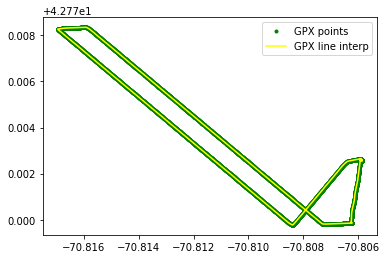

In [8]:
# Export CSV: logfile_gpx.csv stored in same folder as logfile
gpxdf.to_csv(navcsvoutfile, index=False)
print ("Exported outout CSV file called:", navcsvoutfile,"\n")

#%% PLOT!  -- modified from EmilyS
fig = plt.figure()
plt.plot(gpxdf.lon,gpxdf.lat,'.', c='green', label="GPX points")
ax = fig.add_subplot(111)
ax.plot(gpxdf.lon,gpxdf.lat,'-', c='yellow', label="GPX line interp")
ax.legend()
#plt.show()
fig.savefig(os.path.join(homedir, "{}_gpxtrack.png".format(os.path.splitext(logfile)[0])))
#fig.clear()


### Plot GPX on basemap using Leaflet

In [9]:
# Plot it on a map using Leaflet and aerial photo background
## need to figure out a way to cache the map layer or load a geotiff so we can do this offline

fig = plt.figure()
plt.plot(gpxdf.lon,gpxdf.lat,'.', c='green')
ax = fig.add_subplot(111)
ax.plot(gpxdf.lon,gpxdf.lat,'-', c='yellow')

import mplleaflet
mplleaflet.show(tiles='esri_aerial')
print ("Printing map for "+ fc_id +" in new window")

## need to figure out how to save as PNG file too
os.system("cp ./_map.html " + homedir + "/tlogs/" + flight + "_map.html")

Printing map for r01f06 in new window


0

### Work on the photos

In [10]:
#from EmilyS
# List all JPEGS in imagefolder
flist=[os.path.join(imagefolder,f) for f in os.listdir(imagefolder) if f.lower().endswith('.jpg')]
print("Found {} images in {}.".format(len(flist),imagefolder))

# Set datetime format
fmt = '%Y:%m:%d %H:%M:%S' #2017-05-04 14:14:12

Found 258 images in /Data/2018_PlumIsland/2018_015_FA_PlumIs_Feb/test_script/ricoh/images/f6.


In [11]:
#from EmilyS
dt = [datetime.datetime.strptime(Image.open(f)._getexif()[36867], fmt) for f in flist]
imgdf = pd.DataFrame({'orig_name': [os.path.basename(f) for f in flist],
                      'time_utc': dt,
                      'time_epoch': pd.to_datetime(dt, format = '%Y-%m-%d %H:%M:%S'),
                      'time_iso': [t.strftime(iso_fmt) for t in dt],
                      'new_name': np.nan,
                      'lon': np.nan,
                      'lat': np.nan,
                      'ele': np.nan,
                      'interpolated': 0},
                        columns=['new_name', 'lat', 'lon', 'ele', 'time_utc', 'orig_name', 'time_epoch', 'time_iso', 'interpolated'])

## for some reason I can't get it to create the epoch time while creating the imgdf
## but these next 2 lines seems to work after the imgdf is created
imgdf['time_epoch'] = pd.to_datetime(imgdf['time_utc'], format = '%Y-%m-%d %H:%M:%S')
imgdf['time_epoch'] = imgdf['time_utc'].astype(np.int64) // 10**9
#imgdf['new_name'] = imgdf['new_name'].replace("-","")

imgdf

,new_name,lat,lon,ele,time_utc,orig_name,time_epoch,time_iso,interpolated
0,NaN,NaN,NaN,NaN,2018-02-27 19:18:07,P0027219.JPG,1519759087,20180227T191807Z,0
1,NaN,NaN,NaN,NaN,2018-02-27 19:18:09,P0027220.JPG,1519759089,20180227T191809Z,0
2,NaN,NaN,NaN,NaN,2018-02-27 19:18:11,P0027221.JPG,1519759091,20180227T191811Z,0
...,...,...,...,...,...,...,...,...,...
255,NaN,NaN,NaN,NaN,2018-02-27 19:26:37,P0027474.JPG,1519759597,20180227T192637Z,0
256,NaN,NaN,NaN,NaN,2018-02-27 19:26:39,P0027475.JPG,1519759599,20180227T192639Z,0
257,NaN,NaN,NaN,NaN,2018-02-27 19:26:41,P0027476.JPG,1519759601,20180227T192641Z,0


Exported photo CSV file called: /Data/2018_PlumIsland/2018_015_FA_PlumIs_Feb/test_script/ricoh/f6_imgtmp.csv 

First file: P0027219.JPG, time: 2018-02-27 19:18:07
Last file: P0027476.JPG, time: 2018-02-27 19:26:41 

GPX data: /Data/2018_PlumIsland/2018_015_FA_PlumIs_Feb/test_script/ricoh/tlogs/f6.gpx from 2018-02-27 19:10:13 to 2018-02-27 19:27:57


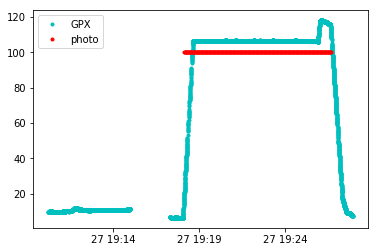

In [12]:
# Export CSV for original photo EXIF times
imgcsvoutfile = os.path.join(homedir, flight+'_imgtmp.csv')
imgdf.to_csv(imgcsvoutfile, index=False)
print ("Exported photo CSV file called:", imgcsvoutfile,"\n")
            
# print first and last image name and times
print("First file: {}, time: {}".format(imgdf.orig_name.iloc[0],imgdf.time_utc.iloc[0]))
print("Last file: {}, time: {}".format(imgdf.orig_name.iloc[-1],imgdf.time_utc.iloc[-1]),"\n")
# print first and last times in .gpx file
print("GPX data: {} from {} to {}".format(logfile, gpxdf.datetime_utc.iloc[0],gpxdf.datetime_utc.iloc[-1]))

#%% Plot times of image vs GPX data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(gpxdf.datetime_utc, gpxdf.ele,'.c', label='GPX')
ax.plot(imgdf.time_utc, np.tile(gpxdf.ele.max(), imgdf.shape[0]),'.r', label='photo')
ax.legend()
#fig.clear()

### Image Rename

In [13]:
imgdf

,new_name,lat,lon,ele,time_utc,orig_name,time_epoch,time_iso,interpolated
0,NaN,NaN,NaN,NaN,2018-02-27 19:18:07,P0027219.JPG,1519759087,20180227T191807Z,0
1,NaN,NaN,NaN,NaN,2018-02-27 19:18:09,P0027220.JPG,1519759089,20180227T191809Z,0
2,NaN,NaN,NaN,NaN,2018-02-27 19:18:11,P0027221.JPG,1519759091,20180227T191811Z,0
...,...,...,...,...,...,...,...,...,...
255,NaN,NaN,NaN,NaN,2018-02-27 19:26:37,P0027474.JPG,1519759597,20180227T192637Z,0
256,NaN,NaN,NaN,NaN,2018-02-27 19:26:39,P0027475.JPG,1519759599,20180227T192639Z,0
257,NaN,NaN,NaN,NaN,2018-02-27 19:26:41,P0027476.JPG,1519759601,20180227T192641Z,0


In [14]:
# Rename photos - modified slightly from EmilyS
#TODO move/copy them first? / don't run if the names have already been changed...
survey_id = fan.replace("-","")
rename_photos = True

for idx, row in imgdf.iterrows():
    img = row.orig_name
    namestr = "{}_{}_{}_{}".format(survey_id, fc_id, row.time_iso, img) # ->
    if rename_photos:
        os.rename(os.path.join(imagefolder, img), os.path.join(imagefolder, namestr))
    imgdf.loc[idx, 'new_name'] = namestr

### EXIF GeoTag & add USGS EXIF meta to Images

In [15]:
# Run the ExifTool command to geotag images with a GPX file
# I needed to hard code the location of exiftools - this might be different depending on ExifTools install
#    if needed, you can always run it at the command line flight-by-flight

## command line syntax:
## exiftool -geosync=-0:0:0 -geotag ./tlogs/f6.gpx ./images/f6

##Use first line to run on a specific (hardcoded) gpx/photo set; use 2nd line to run within the Python processing flow
#os.system("/usr/local/bin/exiftool -geosync=-0:0:0 -geotag " + homedir + "/tlogs/f11.gpx " + homedir + "/images/f11")
os.system("/usr/local/bin/exiftool -geosync=-0:0:0 -geotag " + logfile + " " + imagefolder)  

# Run ExifTool again to update other USGS specific meta tags
write_WHSC_exiftags(imgdir, credit, comment, keywords)

True